In [1]:
import os
import shutil
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 
import glob
import random
import tensorflow as tf
import keras.utils as image

random.seed(42)
tf.random.set_seed(42)

from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
import pickle
import keras_tuner as kt
import tensorflow.keras.backend as K

# About the Model

This is a classic CNN architecture comprising three convolutional blocks. In each block, BatchNorm is utilized (primarily for controlling gradients) and MaxPooling is employed (for reducing the number of parameters). Subsequently, the output of the convolutional blocks is connected to a fully connected (FC) layer. Within the FC layer, dropout is implemented to mitigate the potential for overfitting. (To learn more about dropout and its role in deep learning, you can refer to [this](https://www.kaggle.com/code/egemenuurdalg/replicating-experiments-3-the-role-of-dropout) notebook.)

# Content

1. [Reading the Data](#1)
2. [Model Optimization](#2)
3. [Training the Final Model](#3)
4. [Calculating the Number of Parameters and Amount of Mult Adds Needed](#4)



<a id='1'></a>
## 1. Reading the Data

In [2]:
breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)
data = pd.read_csv("/kaggle/input/selected-images/selected_images.csv")

In [3]:
# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.3, random_state=42)
val_data,test_data = train_test_split(val_data,test_size = 0.5, random_state = 42)


# Set preprocessing and hyperparameter settings
datagen = ImageDataGenerator(rescale=1./255)
target_size = (50, 50)
batch_size = 32

# Create the training and validation generators
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col="path",
    y_col="label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='raw')

val_generator = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col="path",
    y_col="label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='raw')

test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col="path",
    y_col="label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='raw')



Found 56000 validated image filenames.
Found 12000 validated image filenames.
Found 12000 validated image filenames.


In [4]:
A,B = np.unique(train_generator.labels, return_counts = True)
n = len(train_generator.labels)
cls_weights = {i:(n-j)/n for i,j in zip(A,B)}

In [5]:
# If tf.nightly works in your notebook you can also use tf.keras.metrics.F1Score()
# Don't recommend to use tfa.metrics.F1Score() cause the results are not reliable. You have to enter number of classes as 1 since output node has one units.
# When you run the model based on that the F1 Score stucks at 0.44 in all iterations
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

<a id='2'></a>
## 2. Model Optimization

In [6]:
#def model_builder(hp):
#    model = tf.keras.Sequential()
    # Add the first convolutional layer
#    conv_units = hp.Int('conv_units', min_value = 16, max_value = 64,step = 16)
#    model.add(layers.Conv2D(conv_units, (3, 3), activation='relu', input_shape=(50, 50, 3)))
#    model.add(layers.BatchNormalization())
#    model.add(layers.MaxPooling2D((2, 2)))

    # Add more convolutional layers
#    model.add(layers.Conv2D(conv_units*2, (3, 3), activation='relu'))
#    model.add(layers.BatchNormalization())
#    model.add(layers.MaxPooling2D((2, 2)))

#    model.add(layers.Conv2D(conv_units*4, (3, 3), activation='relu'))
#    model.add(layers.BatchNormalization())
#    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output of the previous layer
#    model.add(layers.Flatten())

    # Add fully connected layers
#    model.add(layers.Dense(conv_units*2, activation='relu'))
#    model.add(layers.BatchNormalization())
#    model.add(layers.Dropout(0.5))

#    model.add(layers.Dense(1, activation='sigmoid'))  

    
#    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2,1e-3,1e-4])
#    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = hp_learning_rate), loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(),
#                                                                        tf.keras.metrics.Recall(),f1_score])
#    return model

In [7]:
#tuner = kt.Hyperband(model_builder,
#                     objective=kt.Objective('f1_score', direction='max'),
#                     max_epochs=10,
#                     factor=3,
#                     directory='my_dir',
#                     project_name='optimize_cnn')


In [8]:
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#tuner.search(train_generator, epochs=50, validation_data = val_generator, callbacks=[stop_early])

#Get the optimal hyperparameters
#best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

#print(f"""
#The hyperparameter search is complete. The optimal number of units in the first densely-connected
#layer is {best_hps.get('conv_units')} and the optimal learning rate for the optimizer
#is {best_hps.get('learning_rate')}.
#""")

<a id='3'></a>
## 3. Training the Final Model

In [9]:
def train_best_model(units, learning_rate):
    model = tf.keras.Sequential()
   
    # 1. block
    model.add(layers.Conv2D(units, (3, 3), activation='relu', input_shape=(50, 50, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # 2. block
    model.add(layers.Conv2D(units*2, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # 3. block
    model.add(layers.Conv2D(units*4, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # FC Block
    model.add(layers.Dense(units*2, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1, activation='sigmoid'))  

    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate), loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(),
                                                                        tf.keras.metrics.Recall(),f1_score])

 

    history = model.fit(train_generator, validation_data=val_generator, epochs=300,
                        callbacks=tf.keras.callbacks.EarlyStopping(patience=5,
                                                                   min_delta=0.001,
                                                                   monitor='val_loss'),
                        class_weight=cls_weights)
    
    test_results = model.evaluate(test_generator)
    
    return model, history, test_results



In [10]:
#results obtained from keras tuner
best_settings = {
    'learning_rate': 0.001,
    'units': 64
}
model, history, test_results = train_best_model(**best_settings)

Epoch 1/300
1750/1750 [==============================] - 400s 223ms/step - loss: 0.1891 - precision: 0.6099 - recall: 0.8092 - f1_score: 0.6863 - val_loss: 0.6547 - val_precision: 0.7920 - val_recall: 0.3328 - val_f1_score: 0.4487
Epoch 2/300
1750/1750 [==============================] - 71s 41ms/step - loss: 0.1658 - precision: 0.6477 - recall: 0.8247 - f1_score: 0.7162 - val_loss: 1.0691 - val_precision: 0.7615 - val_recall: 0.1518 - val_f1_score: 0.2312
Epoch 3/300
1750/1750 [==============================] - 73s 42ms/step - loss: 0.1591 - precision: 0.6643 - recall: 0.8339 - f1_score: 0.7299 - val_loss: 0.4330 - val_precision: 0.8040 - val_recall: 0.5526 - val_f1_score: 0.6357
Epoch 4/300
1750/1750 [==============================] - 80s 46ms/step - loss: 0.1543 - precision: 0.6752 - recall: 0.8436 - f1_score: 0.7404 - val_loss: 0.3994 - val_precision: 0.7272 - val_recall: 0.7103 - val_f1_score: 0.7034
Epoch 5/300
1750/1750 [==============================] - 71s 40ms/step - loss: 0.1

In [11]:
model.save('cnn_model.h5')

with open('cnn_model_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
    
with open('cnn_test_results.pkl', 'wb') as file:
    pickle.dump(test_results, file)

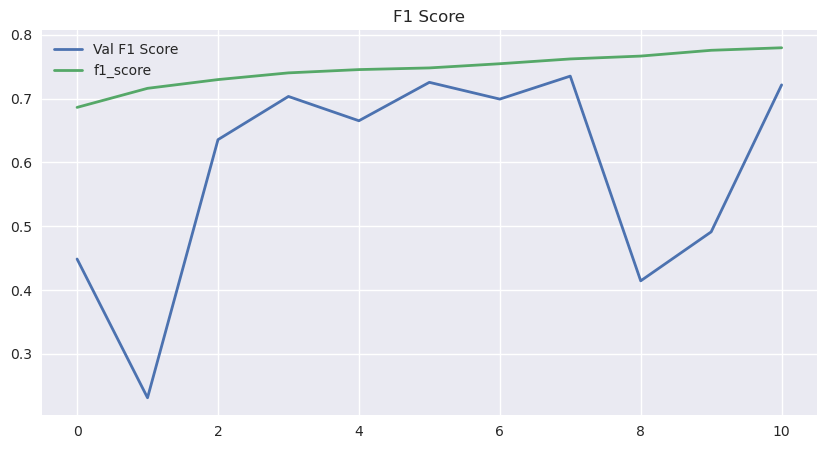

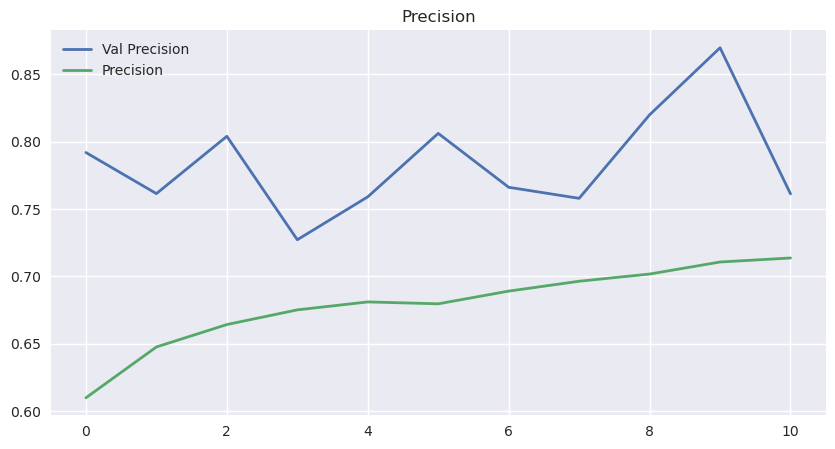

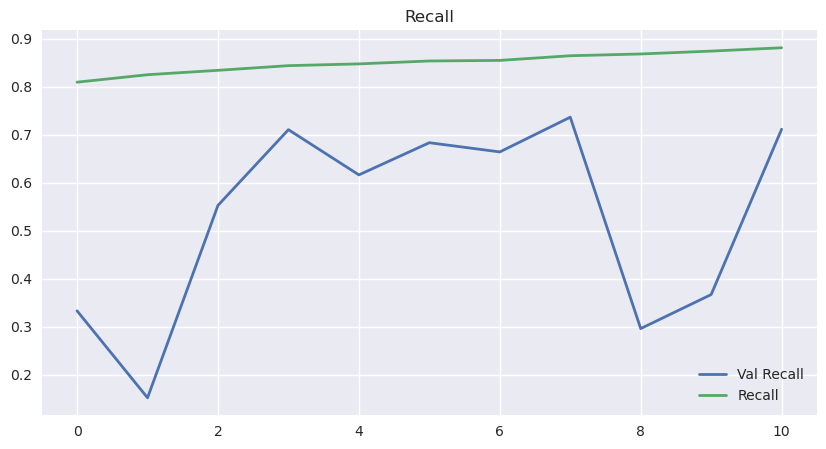

In [12]:
def plot_the_results(history):
    plt.style.use('seaborn')
    plt.figure(figsize = (10,5))
    plt.plot(history.epoch,history.history['val_f1_score'], label = 'Val F1 Score',linewidth=2)
    plt.plot(history.epoch,history.history['f1_score'], label = 'f1_score',linewidth=2)
    plt.legend()
    plt.title('F1 Score')
    plt.show()

    plt.figure(figsize = (10,5))
    plt.plot(history.epoch,history.history['val_precision'], label = 'Val Precision',linewidth=2)
    plt.plot(history.epoch,history.history['precision'], label = 'Precision',linewidth=2)
    plt.legend()
    plt.title('Precision')
    plt.show()
    
    plt.figure(figsize = (10,5))
    plt.plot(history.epoch,history.history['val_recall'], label = 'Val Recall',linewidth=2)
    plt.plot(history.epoch,history.history['recall'], label = 'Recall',linewidth=2)
    plt.legend()
    plt.title('Recall')
    plt.show()
    
plot_the_results(history)

In [13]:
print("Test Results")
print("\n-------------\n")
print("Test Loss:",format(test_results[0],'.3f'))
print("Test Precision: ",format(test_results[1], '.3f'))
print("Test Recall: ", format(test_results[2],'.3f'))
print("Test F1: ", format(test_results[3],'.3f'))

Test Results

-------------

Test Loss: 0.411
Test Precision:  0.756
Test Recall:  0.715
Test F1:  0.727


<a id='4'></a>
## 4. Calculating the Number of Parameters and Amount of Mult Adds Needed

In [14]:
total_parameters = model.count_params()
mult_adds_total = 0
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        height, width, channels_in = layer.input_shape[1:]
        _, _, channels_out = layer.output_shape[1:]
        kernel_height, kernel_width = layer.kernel_size

        mult_adds = height * width * channels_in * channels_out * kernel_height * kernel_width
        mult_adds_total += mult_adds
        
        
print("Total parameters:", total_parameters)
print("Total number of multipy-accumulates:", mult_adds_total)

Total parameters: 897665
Total number of multipy-accumulates: 82471680
